# Credit scoring problem

## Objective
- Create a credit scoring algorithm that predicts the chance of a given loan applicant defaulting on loan repayment.
- What are the different factors which affect the target variable? What business recommendations can we give based on the analysis?
- How can we improve model performance using hyperparameter tuning and prevent data leakage using pipelines while building a model to predict the response of a customer?

## Third Session
- Data processing & EDA (Missing data analysis and treatment, Outlier treatment , 
- Base model
- Feature Selection & experimentation (Multicollinearity - VIF & Correlation matrix )

## Fourth Class
- Parameter tuning
- Misclassification analysis
- Sub population analysis
- Loss rate analysis
- Productionization

### Data Description

- Target: Target Column 0-Low Credit Risk 1-High Credit Risk
- Customer_ID: Customer ID
- OVD_t1: number of times overdue type 1
- OVD_t2: number of times overdue type 2
- OVD_t3: number of times overdue type 3
- OVD_sum: total overdue days
- pay_normal: number of times normal payment
- prod_code: credit product code
- loan_date: date when loan was issued
- feature_1: no definition
- feature_2: no definition
- feature_3: no definition (Assume it means customer age)
- feature_4: no definition (Assume it means monthly salary)
- feature_5: no definition (Assume it means no of products purchased before)
- feature_6: no definition
- feature_7: no definition
- feature_8: no definition
- feature_9: no definition
- feature_10: no definition
- feature_11: no definition
- age : the age of the customer (simulated)
- cust_tenor : months since onboarding
- dpd_before: historic days past due before loan was taken
- loans_before: historic count of loans
- cust_type: type of customer (1 = salaried, 0 = business)

### Importing Libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# This line will suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<IPython.core.display.Javascript object>

### Loading Data

In [2]:
jmd = pd.read_excel("data/modelling_data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
# Checking the number of rows and columns in the data
jmd.shape

(1125, 20)

<IPython.core.display.Javascript object>

* The dataset has 1125 rows and 20 columns 

## Data Overview

In [5]:
# let's create a copy of the data
data = jmd.copy()

<IPython.core.display.Javascript object>

In [10]:
# let's view the first 5 rows of the data
# data.head(5)
data.sample(5)

,Customer_ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,Target,loan_date,age,cust_tenor(months),dpd_before(days),loans_before,cust_type,location
305,10858987161,5,NaN,2,48000,2,15,5,107,4,450008,178.006,0,2017-02-01,19.000,78,19.000,0.000,1 - Business,Thika
519,96158990002,7,1277.000,3,101000,2,11,9,106,4,450050,200.070,0,2018-05-16,82.000,114,16.000,5.000,1 - Business,Nairobi
163,30058987886,5,1269.500,1,175000,2,15,5,110,5,350057,173.205,0,2017-05-23,59.000,95,22.000,1.000,1 - Business,Kikuyu
676,11058990308,7,1307.000,3,195000,2,11,9,95,5,72003,200.000,0,2020-10-22,21.000,30,14.000,4.000,0 - Salaried,Meru
767,8554984201,5,1250.000,3,79000,2,15,5,110,4,72001,1.000,0,2018-08-20,92.000,14,26.000,4.000,0 - Salaried,Nairobi


<IPython.core.display.Javascript object>

In [54]:
# let's view the last 5 rows of the data
data.tail()

,Customer_ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,Target,loan_date,age,cust_tenor(months),dpd_before(days),loans_before,cust_type,location
1120,6958988196,5,1289.000,1,173000,2,15,5,112,3,350702,200.000,0,2016-04-25,99.000,113,21.000,3.000,0 - Salaried,NaN
1121,46758987926,5,NaN,2,50000,2,15,5,108,4,450000,169.000,0,2020-02-23,64.000,9,16.000,4.000,0 - Salaried,NaN
1122,39258995381,7,1220.000,3,76000,2,11,2,90,5,71002,1.000,0,2018-07-12,39.000,59,5.000,0.000,0 - Salaried,NaN
1123,69558998054,4,1250.000,3,137000,2,8,5,90,5,72000,1.000,0,2014-01-20,58.000,104,11.000,4.000,1 - Business,NaN
1124,85754989781,4,1415.000,3,93000,2,8,5,113,4,151300,273.861,0,2017-03-15,50.000,67,2.000,5.000,0 - Salaried,NaN


In [55]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Customer_ID         1125 non-null   int64         
 1   feature_1           1125 non-null   int64         
 2   feature_2           976 non-null    float64       
 3   feature_3           1125 non-null   int64         
 4   feature_4           1125 non-null   int64         
 5   feature_5           1125 non-null   int64         
 6   feature_6           1125 non-null   int64         
 7   feature_7           1125 non-null   int64         
 8   feature_8           1125 non-null   int64         
 9   feature_9           1125 non-null   int64         
 10  feature_10          1125 non-null   int64         
 11  feature_11          1125 non-null   float64       
 12  Target              1125 non-null   int64         
 13  loan_date           1125 non-null   datetime64[n

### Tasks1
try out different experiments by imputing diff columns
- impute age with mean
- impute age with median
- drop rows without age
- impute dpd_before(days) with 1, median, mean, etc
- impute loans_before with 1, median, mean, etc
- impute location with 'unknown, drop'

In [12]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [13]:
# let's check for missing values in the data
round(data.isnull().sum() / data.isnull().count() * 100, 2)

Customer_ID           0.000
feature_1             0.000
feature_2            13.240
feature_3             0.000
feature_4             0.000
feature_5             0.000
feature_6             0.000
feature_7             0.000
feature_8             0.000
feature_9             0.000
feature_10            0.000
feature_11            0.000
Target                0.000
loan_date             0.000
age                   0.800
cust_tenor(months)    0.000
dpd_before(days)      0.090
loans_before          1.330
cust_type             0.000
location             22.040
dtype: float64

<IPython.core.display.Javascript object>

**Observations:** 
##### What are some of the observations you see from the above diplay?
- How can dpd_before be null where we have loans_before?
- How do we handle null values?

In [14]:
# let's view the statistical summary of the numerical columns in the data
data.describe().T
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

,count,mean,std,min,25%,50%,75%,max
Customer_ID,1125.000,49924681215.827,28451278917.904,258991618.000,25359002553.000,50858991271.000,73954992137.000,99754986167.000
feature_1,1125.000,5.483,1.383,1.000,4.000,5.000,7.000,7.000
feature_2,976.000,1283.911,51.764,1116.500,1244.000,1281.500,1314.500,1481.000
feature_3,1125.000,2.333,0.879,1.000,1.000,3.000,3.000,3.000
feature_4,1125.000,120883.556,88445.229,15000.000,72000.000,102000.000,139000.000,1200000.000
feature_5,1125.000,1.929,0.257,1.000,2.000,2.000,2.000,2.000
feature_6,1125.000,10.872,2.676,3.000,8.000,11.000,11.000,16.000
feature_7,1125.000,4.833,2.971,-1.000,5.000,5.000,5.000,10.000
feature_8,1125.000,100.803,11.989,64.000,90.000,105.000,111.000,115.000
feature_9,1125.000,4.196,0.856,1.000,3.000,4.000,5.000,5.000


<IPython.core.display.Javascript object>

**Observations:** 
##### What are some of the observations you see from the above diplay?
- `Age` has a large range of values i.e. 15 to 120.


## Task 2
- review the data above and deduce insights

## Data Preprocessing

- We can drop the column - `Customer ID` as it is unique for each customer and will not add value to the model.

In [15]:
# Dropping column - ID
data.drop(columns=["Customer_ID"], inplace=True)

<IPython.core.display.Javascript object>

In [17]:
# Convert column names to lowercase for ease of coding
data = data.rename(columns=str.lower)

<IPython.core.display.Javascript object>

In [19]:
# data.columns.tolist()

<IPython.core.display.Javascript object>

**Adding age of the customers to the data using given birth years**

In [21]:
# Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.
bins= [0,18,25,35,50,65,85,120]
labels = ['0-17','18-24','25-34','35-49', '50-64', '65-84', '85-150']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

data["age_group"].value_counts(1)

65-84    0.208
25-34    0.187
35-49    0.157
85-150   0.144
18-24    0.133
50-64    0.133
0-17     0.039
Name: age_group, dtype: float64

<IPython.core.display.Javascript object>

- We can see that there are 3 observations with ages greater than 85, create more bins within this group
- We can drop the observations with age greater than 120

In [44]:
data[data["age"] > 95]

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target,loan_date,age,cust_tenor(months),dpd_before(days),loans_before,cust_type,age_group
35,4,1364.000,1,200000,2,8,5,90,3,60022,212.132,0,2014-02-26,97.000,102,16.000,4.000,1,85-150
51,5,1241.000,3,60000,2,15,5,90,5,60000,200.000,0,2014-01-23,96.000,103,16.000,2.000,0,85-150
89,7,1266.500,1,165000,2,11,5,111,3,60084,1.000,0,2019-04-16,99.000,118,26.000,2.000,0,85-150
104,7,1256.000,1,126000,2,11,9,102,3,350705,158.114,0,2019-09-17,96.000,8,29.000,2.000,1,85-150
121,4,1340.000,3,116000,2,8,9,104,5,72000,1.000,0,2012-10-26,100.000,94,26.000,2.000,1,85-150
140,4,1277.000,3,100000,2,8,5,100,5,60000,223.607,0,2014-02-26,99.000,56,10.000,1.000,0,85-150
157,7,1317.500,3,150000,2,11,5,112,5,450042,345.795,0,2013-04-16,96.000,96,28.000,0.000,1,85-150
160,4,1338.500,3,165000,2,8,5,111,5,151300,288.097,0,2017-07-16,98.000,13,24.000,0.000,1,85-150
247,7,1232.000,1,96000,2,11,9,88,5,151300,233.521,0,2019-07-02,98.000,109,5.000,5.000,1,85-150
252,4,1352.000,1,128000,2,8,5,72,3,60058,1.000,0,2013-11-05,97.000,105,32.000,2.000,0,85-150


In [46]:
# Dropping the 3 observations with age > 100
# data.drop(data[data["age"] > 100].index, inplace=True)

**Using loan_date to add features to the data**

In [47]:
# The feature loan_date represents borrowing dates.
# Let's convert this to DateTime format
data["loan_date"] = pd.to_datetime(data["loan_date"])

In [22]:
# Extracting year from the date
data["loan_year"] = data["loan_date"].apply(lambda x: x.year)

# Extracting quarter from the date
data["loan_quarter"] = data["loan_date"].apply(lambda x: x.quarter)

# Extracting month from the date
data["loan_month"] = data["loan_date"].apply(lambda x: x.month)

# Extracting week from the date
data["loan_week"] = data["loan_date"].apply(lambda x: x.day // 7)

<IPython.core.display.Javascript object>

In [23]:
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target,loan_date,age,cust_tenor(months),dpd_before(days),loans_before,cust_type,location,age_group,loan_year,loan_quarter,loan_month,loan_week
0,5,1245.500,3,77000,2,15,5,109,5,151300,244.949,1,2012-12-09,28.000,0,179.000,1.000,0 - Salaried,Thika,25-34,2012,4,12,1
1,4,1277.000,1,113000,2,8,-1,100,3,341759,207.174,0,2015-09-26,66.000,37,20.000,1.000,0 - Salaried,Nakuru,65-84,2015,3,9,3
2,7,1298.000,1,110000,2,11,-1,101,5,72001,1.000,0,2017-02-25,37.000,86,1.000,4.000,1 - Business,Eldoret,35-49,2017,1,2,3
3,7,1335.500,1,151000,2,11,5,110,3,60084,1.000,1,2017-08-14,16.000,4,281.000,0.000,1 - Business,Ruiru,0-17,2017,3,8,2
4,7,NaN,2,59000,2,11,5,108,4,450081,197.403,0,2012-07-21,75.000,95,10.000,1.000,1 - Business,Nairobi,65-84,2012,3,7,3


<IPython.core.display.Javascript object>

**Let's check the count of each unique category in each of the categorical variables.** 

In [25]:
# Making a list of all categorical variables
cat_col = [
    "age_group",
    "location",
    "cust_type"
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

65-84     232
25-34     209
35-49     175
85-150    161
18-24     148
50-64     148
0-17       43
Name: age_group, dtype: int64
----------------------------------------
Mombasa    103
Nyeri       98
Meru        92
Kikuyu      90
Thika       87
Ruiru       87
Kisumu      87
Eldoret     83
Nairobi     79
Nakuru      71
Name: location, dtype: int64
----------------------------------------
0 - Salaried    712
1 - Business    413
Name: cust_type, dtype: int64
----------------------------------------


<IPython.core.display.Javascript object>

- Mombasa, Nairobi, Kisumu, Nakuru are cities, We can combine these three categories.

In [26]:
# Replacing 2n Cycle with Master
data["nature_of_city"] = np.where(data["location"].isin(['Mombasa', 'Nairobi', 'Kisumu']),'urban','rural')
data["nature_of_city"].value_counts()

rural    856
urban    269
Name: nature_of_city, dtype: int64

<IPython.core.display.Javascript object>

## Task 3
- based on your needs, derive 10 more features from the data shared

## EDA
- Univariate, Bivariate, Target Analysis

### Univariate

In [27]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

- As per the boxplot, there are some outliers in the 'Age' variable
- Age does not have a normal distribution with approx equal mean and median

In [70]:
# data.columns.tolist()

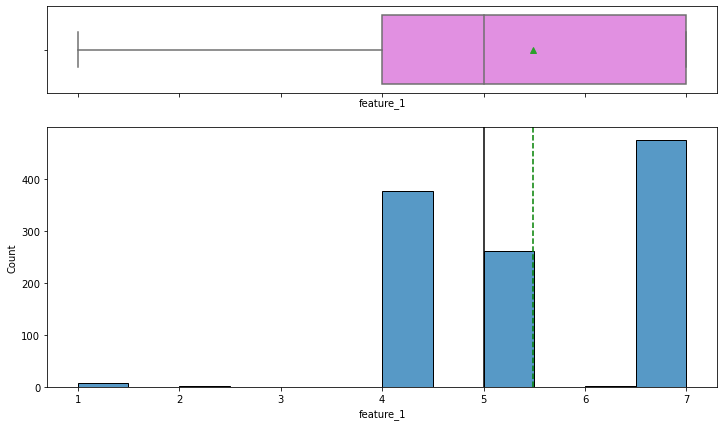

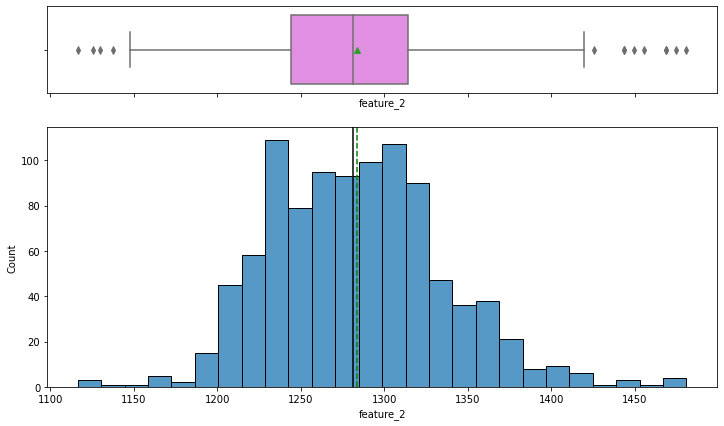

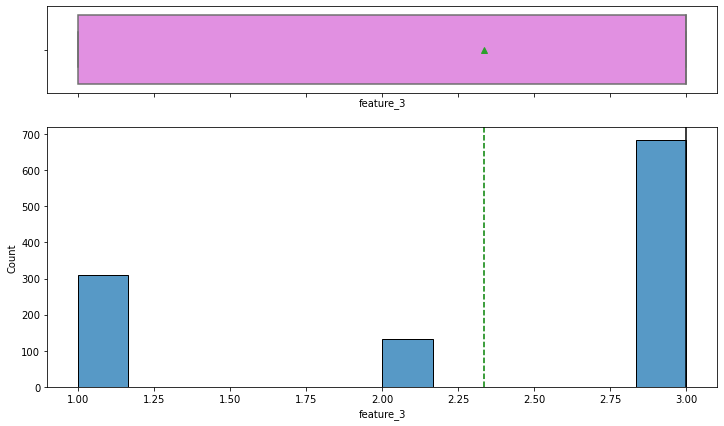

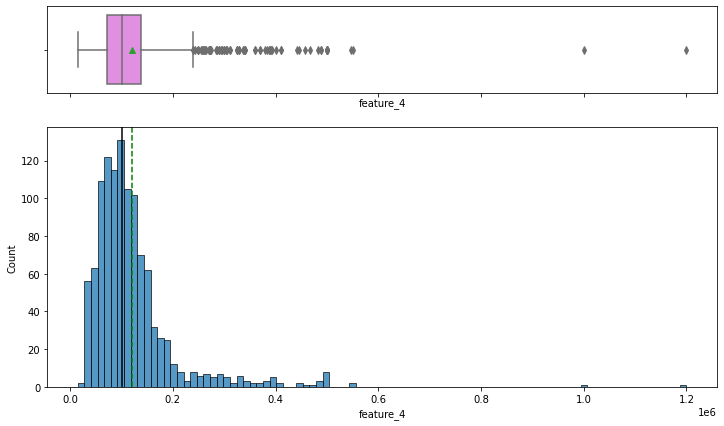

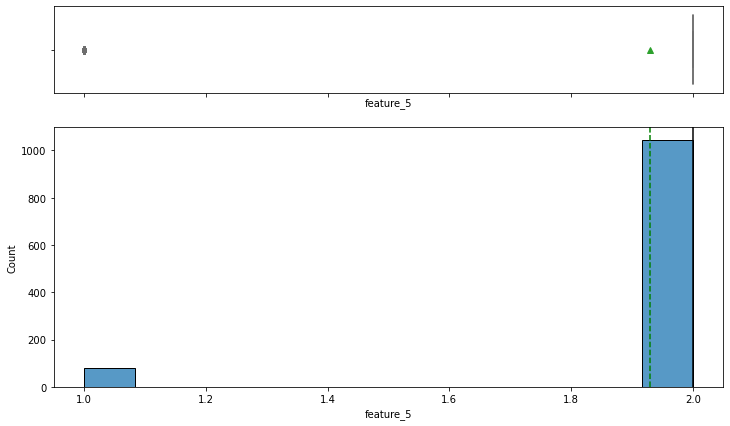

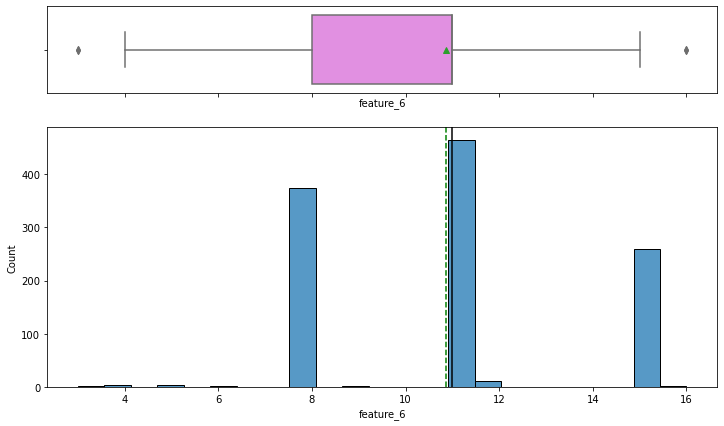

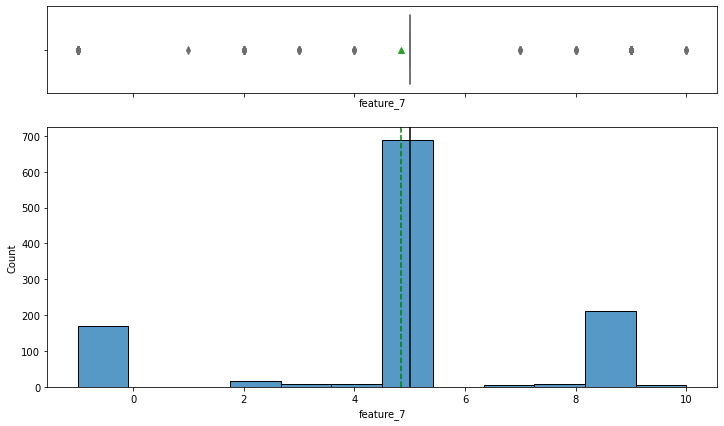

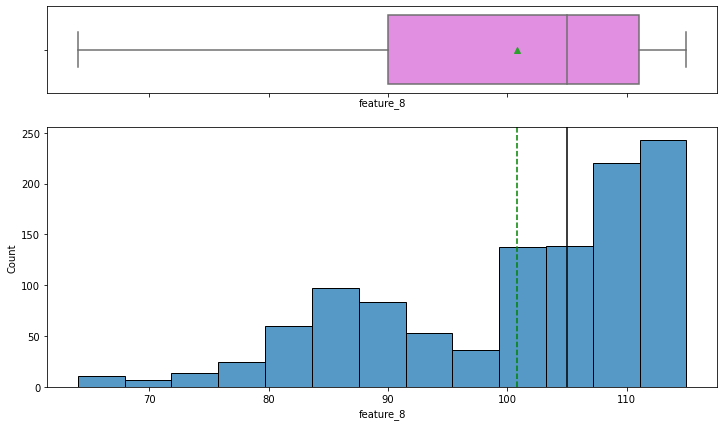

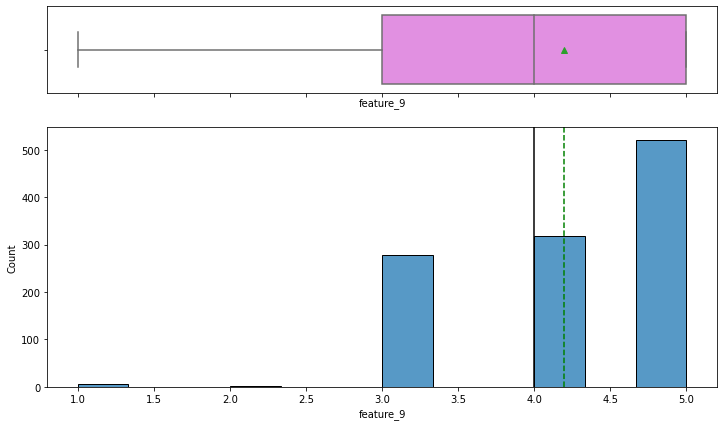

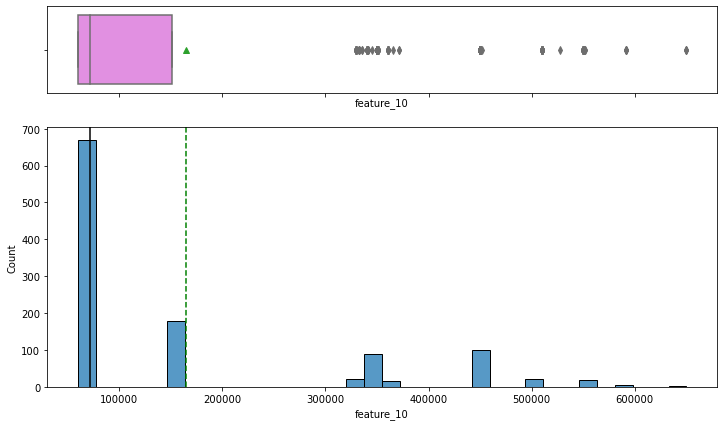

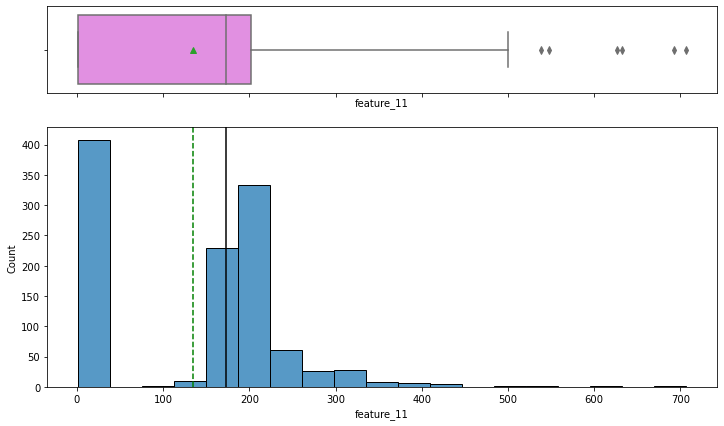

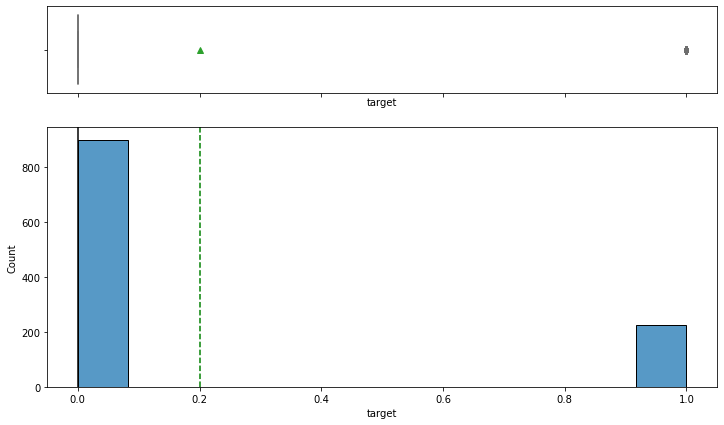

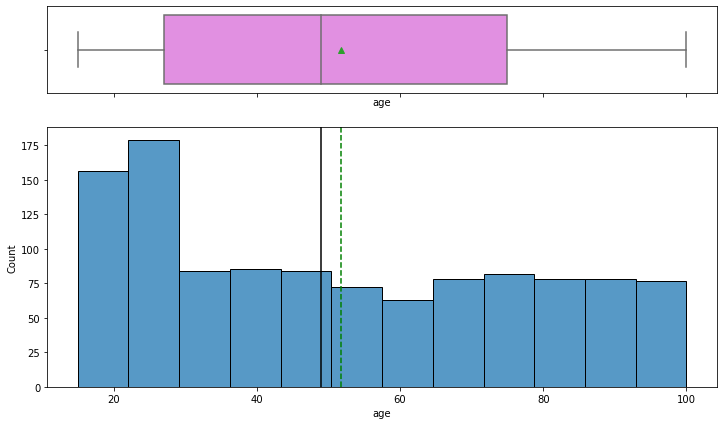

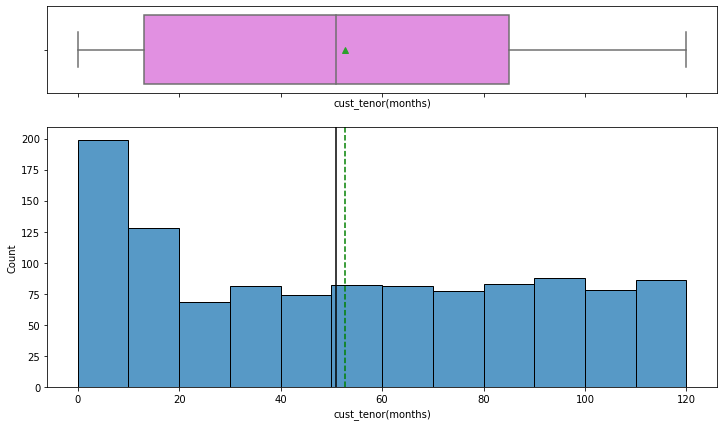

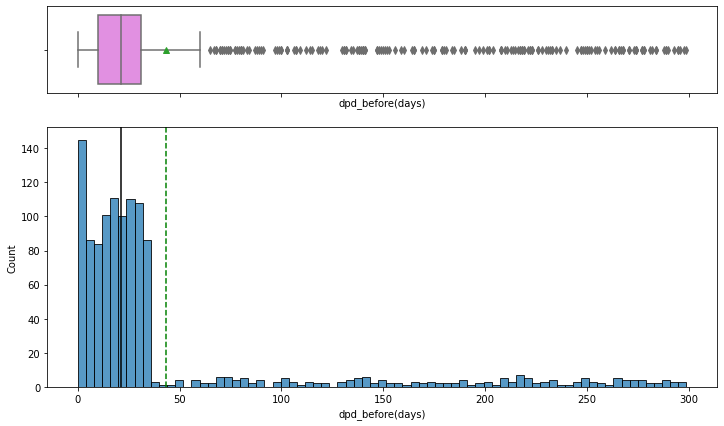

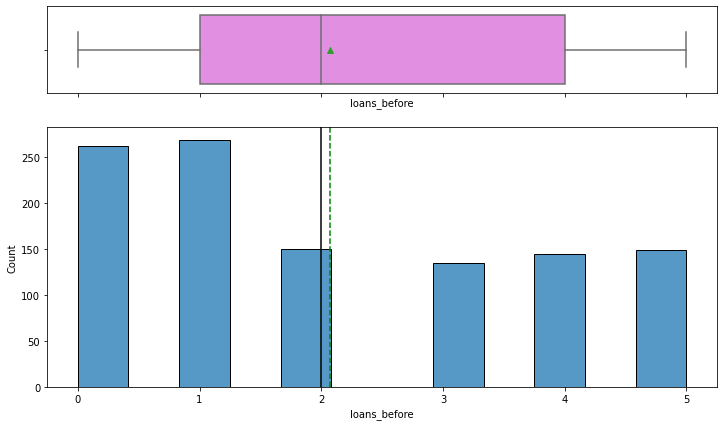

In [74]:
for c in data.select_dtypes(include=np.number).columns.tolist():
    # observations on Income
    histogram_boxplot(data, c)

## Task 4
What insights do you darw from the above chart?

- What insights do you get from the charts?

In [28]:
# Checking 10 largest values of age spend on meat products
data['cust_tenor(months)'].nlargest(10)

23      120
259     120
324     120
697     120
792     120
815     120
1086    120
70      119
222     119
245     119
Name: cust_tenor(months), dtype: int64

<IPython.core.display.Javascript object>

In [29]:
data[data["age"] > 90]

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target,loan_date,age,cust_tenor(months),dpd_before(days),loans_before,cust_type,location,age_group,loan_year,loan_quarter,loan_month,loan_week,nature_of_city
27,5,1455.500,3,35000,2,15,5,92,5,60058,1.000,0,2020-04-17,94.000,69,27.000,0.000,0 - Salaried,Kisumu,85-150,2020,2,4,2,urban
35,4,1364.000,1,200000,2,8,5,90,3,60022,212.132,0,2014-02-26,97.000,102,16.000,4.000,1 - Business,Thika,85-150,2014,1,2,3,rural
51,5,1241.000,3,60000,2,15,5,90,5,60000,200.000,0,2014-01-23,96.000,103,16.000,2.000,0 - Salaried,Kikuyu,85-150,2014,1,1,3,rural
89,7,1266.500,1,165000,2,11,5,111,3,60084,1.000,0,2019-04-16,99.000,118,26.000,2.000,0 - Salaried,Kisumu,85-150,2019,2,4,2,urban
100,7,1283.000,3,90000,2,11,5,85,5,60000,1.000,0,2016-05-21,92.000,50,18.000,2.000,1 - Business,Thika,85-150,2016,2,5,3,rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,4,1292.000,3,195000,2,8,5,112,4,151300,1.000,0,2016-03-17,100.000,16,26.000,5.000,0 - Salaried,NaN,85-150,2016,1,3,2,rural
1099,5,1257.500,3,102000,2,15,2,80,3,60005,223.607,0,2020-06-20,96.000,87,10.000,5.000,0 - Salaried,NaN,85-150,2020,2,6,2,rural
1116,4,1343.000,3,110000,2,8,2,105,5,60043,1.000,0,2016-04-11,99.000,52,34.000,1.000,0 - Salaried,NaN,85-150,2016,2,4,1,rural
1118,7,1137.500,3,88000,2,11,-1,107,4,450081,158.114,0,2019-04-17,92.000,9,25.000,2.000,0 - Salaried,NaN,85-150,2019,2,4,2,rural


<IPython.core.display.Javascript object>

In [30]:
# Capping values for amount spent on meat products at next highest value i.e. 984
data["age"].clip(upper=80, inplace=True)

<IPython.core.display.Javascript object>

In [32]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

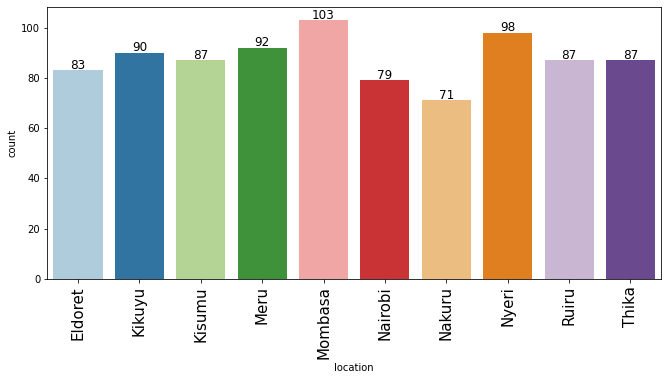

<IPython.core.display.Javascript object>

In [33]:
# observations on Marital_Status
labeled_barplot(data, "location")

- Majority of the customers are married comprising approx 64% of total customers.

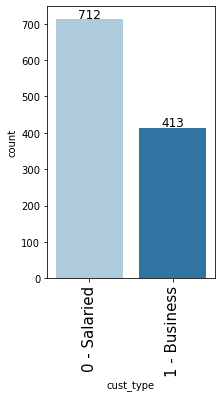

<IPython.core.display.Javascript object>

In [34]:
# observations on Education
labeled_barplot(data, "cust_type")

- what do you see?

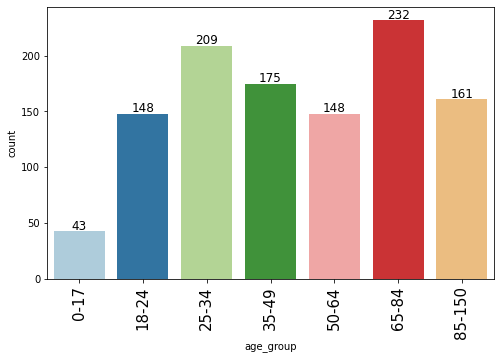

<IPython.core.display.Javascript object>

In [35]:
# observations on Kidhome
labeled_barplot(data, "age_group")

- Add commentary

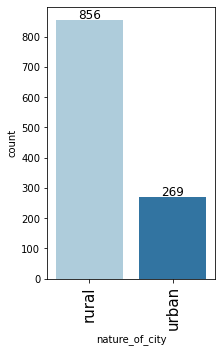

<IPython.core.display.Javascript object>

In [37]:
# observations on Kidhome
labeled_barplot(data, "nature_of_city")

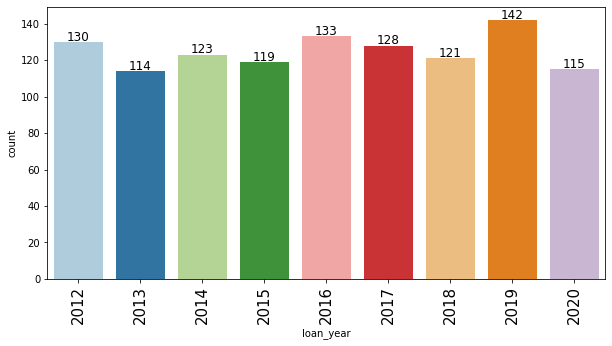

<IPython.core.display.Javascript object>

In [38]:
# observations on loan year
labeled_barplot(data, "loan_year")

- add commentary

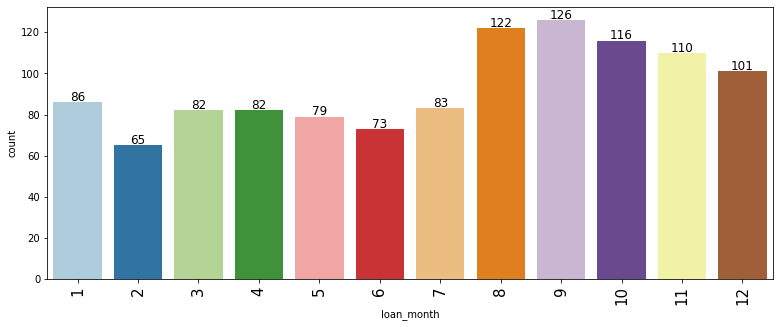

<IPython.core.display.Javascript object>

In [39]:
# observations on Response
labeled_barplot(data, "loan_month")

- Add commentary

## Task 5

review the above charts, what do you see?

### Bivariate Analysis

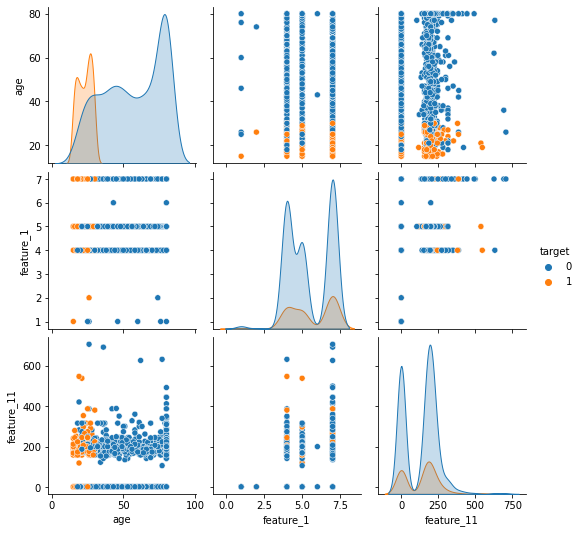

<IPython.core.display.Javascript object>

In [41]:
sns.pairplot(data[['age', 'feature_1', 'feature_11', 'target']], hue="target")

## Task 6
- What can you see from the above?

<AxesSubplot:xlabel='age_group', ylabel='feature_11'>

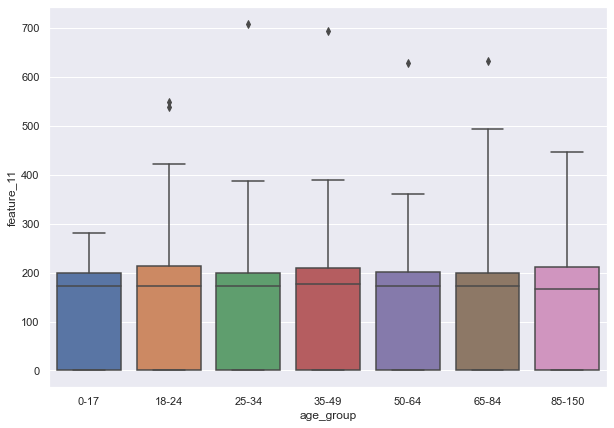

<IPython.core.display.Javascript object>

In [42]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(y="feature_11", x="age_group", data=data, orient="vertical")

- We can see that feature_11 is higher for age_groups 65-84

<AxesSubplot:xlabel='location', ylabel='dpd_before(days)'>

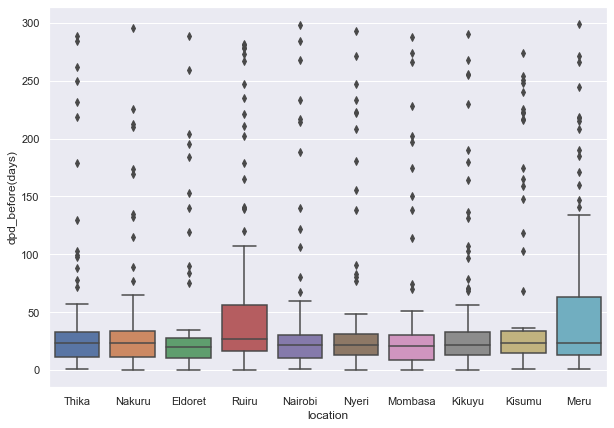

<IPython.core.display.Javascript object>

In [43]:
sns.boxplot(y="dpd_before(days)", x="location", data=data, orient="vertical")

- add commentary

<AxesSubplot:xlabel='loan_year,loan_month'>

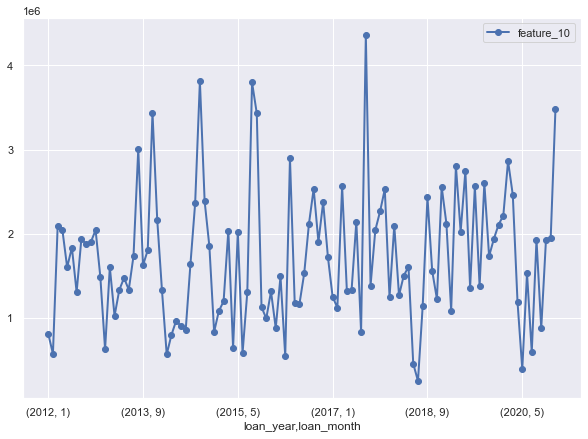

<IPython.core.display.Javascript object>

In [44]:
pd.pivot_table(
    data=data,
    index=["loan_year", "loan_month"],
    values="feature_10",
    aggfunc=np.sum,
).plot(kind="line", marker="o", linewidth=2)

- The plot clearly shows that the loan amount (feature_10) has been stable over the years.
- The plot shows steep increase in the amount spent in september

<AxesSubplot:xlabel='feature_11', ylabel='feature_10'>

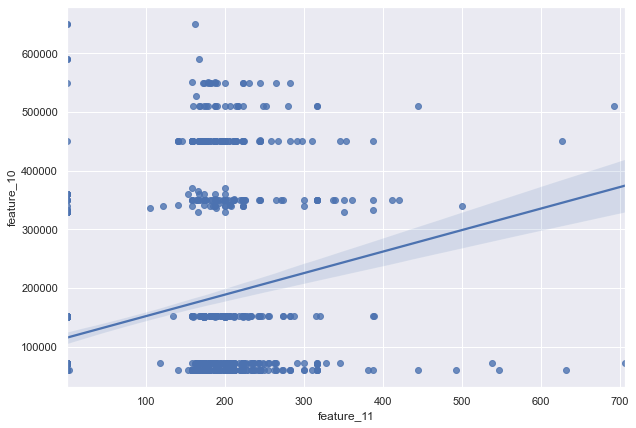

In [93]:
sns.regplot(y=data.feature_10, x=data.feature_11)

#### Sample commentary
- We can see that income and the total amount spent have a positive correlation.
- The total amount spent is not much different for customers with income in the range of 20K to 60K but the difference is significant for customers in the range of 60K to 100K.

V:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
V:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
V:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
V:\anaconda\lib\site-packages\seaborn\_decorators.py:36: Futu

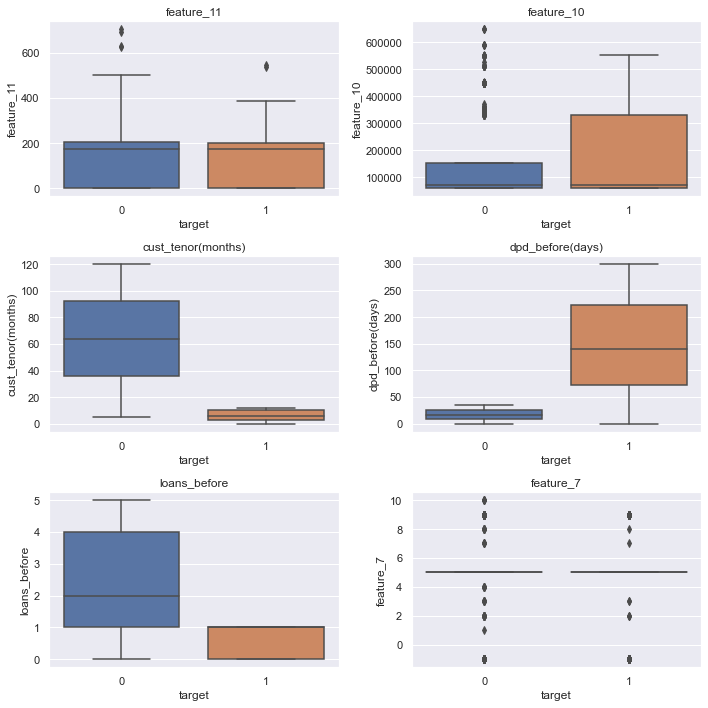

In [94]:
cols = data[
    [
        "feature_11",
        "feature_10",
        "cust_tenor(months)",
        "dpd_before(days)",
        "loans_before",
        "feature_7",
    ]
].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data["target"], data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

## Task 7
- what isnsights can you draw from the above

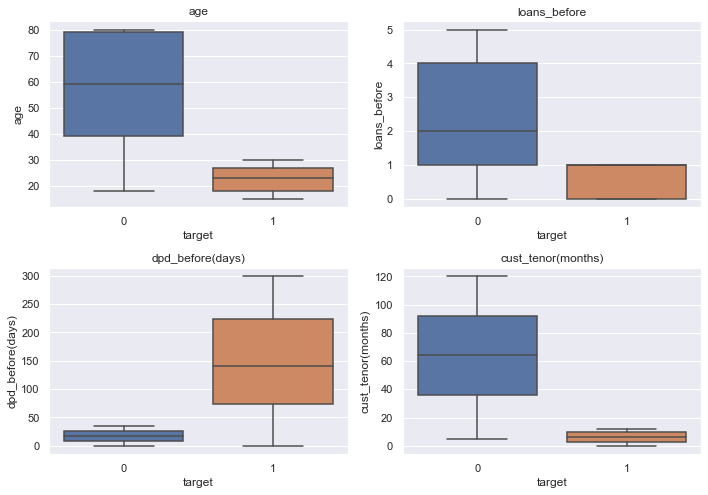

<IPython.core.display.Javascript object>

In [45]:
cols = data[["age", "loans_before", "dpd_before(days)", "cust_tenor(months)"]].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data["target"], data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

#### sample commentary
- Customers with lower recency i.e. less number of days since the last purchase, are more likely to take the offer.
- Response does not depend much on age.
- Customers with higher income are more likely to take the offer.
- Customers who spent more in the last 2 years are more likely to take the offer.

In [46]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

target      0    1  All
location               
All       692  185  877
Meru       67   25   92
Ruiru      62   25   87
Nyeri      74   24   98
Kisumu     65   22   87
Kikuyu     69   21   90
Thika      70   17   87
Mombasa    90   13  103
Nairobi    66   13   79
Nakuru     58   13   71
Eldoret    71   12   83
------------------------------------------------------------------------------------------------------------------------


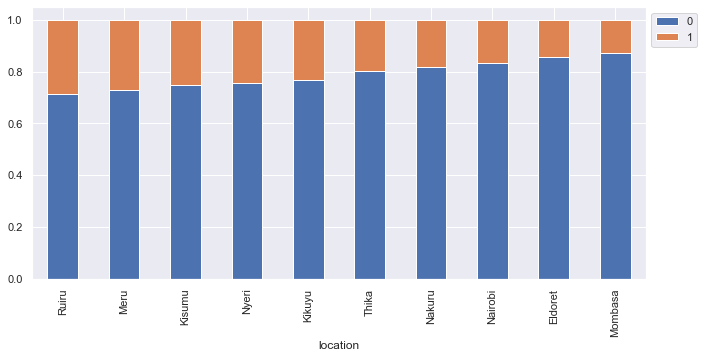

In [97]:
stacked_barplot(data, "location", "target")

#### sample commentary
- We can see a clear trend here that customers with higher education are more likely to take the offer.  

target          0    1   All
cust_type                   
All           900  225  1125
1 - Business  293  120   413
0 - Salaried  607  105   712
------------------------------------------------------------------------------------------------------------------------


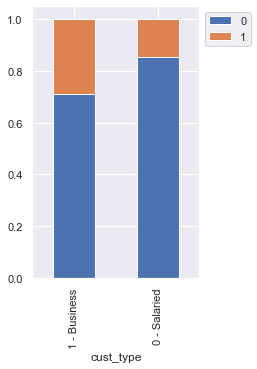

In [98]:
stacked_barplot(data, "cust_type", "target")

add commentary

target       0    1   All
loan_year                
All        900  225  1125
2012       101   29   130
2014        94   29   123
2019       116   26   142
2015        94   25   119
2013        90   24   114
2016       109   24   133
2020        91   24   115
2017       105   23   128
2018       100   21   121
------------------------------------------------------------------------------------------------------------------------


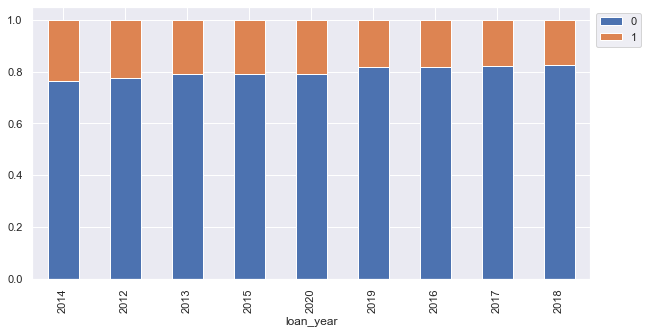

In [100]:
stacked_barplot(data, "loan_year", "target")

- Number of customers taking the offer is decreasing each subsequent year.
- Let's explore this further for month-wise distribution for each of the year.

## Missing-Value Treatment

* Find an appropriate way to handle missing values

### Data Preparation for Modeling

In [48]:
data1 = data.copy()
data1.drop(columns=["loan_date"], inplace=True)

<IPython.core.display.Javascript object>

In [49]:
# create dummy variables
print(data1.shape)
data2 = pd.get_dummies(data1)
print(data2.shape)

(1125, 24)
(1125, 41)


<IPython.core.display.Javascript object>

In [50]:
data2.sample(2)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target,age,cust_tenor(months),dpd_before(days),loans_before,loan_year,loan_quarter,loan_month,loan_week,cust_type_0 - Salaried,cust_type_1 - Business,location_Eldoret,location_Kikuyu,location_Kisumu,location_Meru,location_Mombasa,location_Nairobi,location_Nakuru,location_Nyeri,location_Ruiru,location_Thika,age_group_0-17,age_group_18-24,age_group_25-34,age_group_35-49,age_group_50-64,age_group_65-84,age_group_85-150,nature_of_city_rural,nature_of_city_urban
874,4,1337.000,3,410000,2,8,5,83,5,60091,1.000,0,80.000,47,28.000,4.000,2018,1,3,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
166,7,1266.500,3,130000,2,11,9,100,5,60005,173.205,0,69.000,85,10.000,1.000,2016,2,5,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


<IPython.core.display.Javascript object>

# Task 8
- Convert column names to lower case

## Separating target variable and other variables

In [51]:
# Separating target variable and other variables
# data2 =  data1[data1.select_dtypes(include=np.number).columns.tolist()]

data2.fillna(0, inplace=True)  # inappropriate way of handling nulls

X = data2.drop(columns="target")

Y = data2["target"]

<IPython.core.display.Javascript object>

## Feature selection
1. Check correlation plot
2. Use VIF
3. check feature importance

### Correlation plot

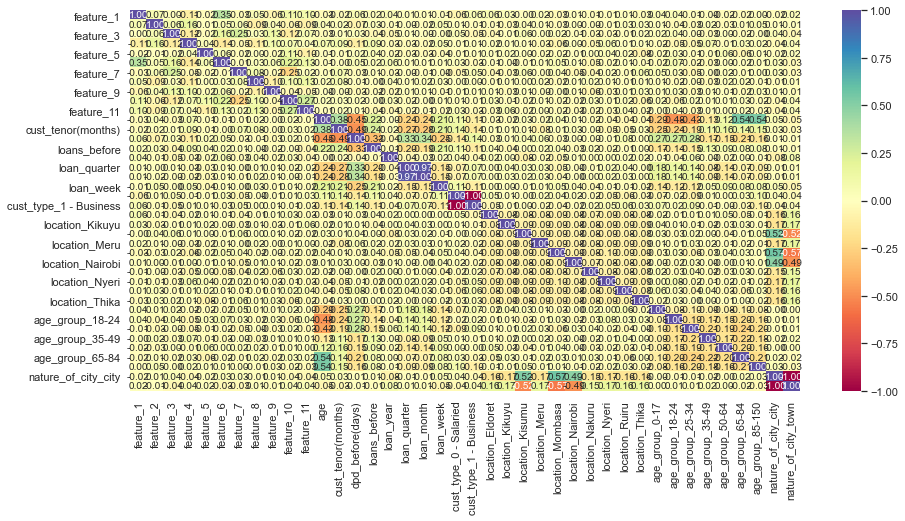

<IPython.core.display.Javascript object>

In [167]:
plt.figure(figsize=(15, 7))
sns.heatmap(X.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

## Task 9
- what insights do you get from this?

### VIF
`Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [54]:
# X.shape

<IPython.core.display.Javascript object>

In [52]:
# statsmodels provides a function named variance_inflation_factor() for calculating VIF.
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# X = np.append(arr=np.ones((50,1)), values=X, axis=1)
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data[vif_data.VIF<=10]

,feature,VIF
0,feature_1,1.192
1,feature_2,1.084
2,feature_3,1.170
3,feature_4,1.150
4,feature_5,1.064
5,feature_6,1.293
6,feature_7,1.181
7,feature_8,1.081
8,feature_9,1.068
9,feature_10,1.286


<IPython.core.display.Javascript object>

# task 10
- what variables do you have with a VIF<10

In [55]:
selected_features = list(vif_data[vif_data.VIF<=10].feature)
print(" a total of {} features have VIFless than 10 : {}".format(len(selected_features),selected_features))
highly_corr_features = list(vif_data[vif_data.VIF>10].feature)
print("a total of {}  highly correlated features dropped by VIF : {}".format(len(highly_corr_features),highly_corr_features))

 a total of 24 features have VIFless than 10 : ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'cust_tenor(months)', 'dpd_before(days)', 'loans_before', 'loan_year', 'loan_week', 'location_Eldoret', 'location_Kikuyu', 'location_Meru', 'location_Nakuru', 'location_Nyeri', 'location_Ruiru', 'location_Thika', 'age_group_0-17']
a total of 16  highly correlated features dropped by VIF : ['age', 'loan_quarter', 'loan_month', 'cust_type_0 - Salaried', 'cust_type_1 - Business', 'location_Kisumu', 'location_Mombasa', 'location_Nairobi', 'age_group_18-24', 'age_group_25-34', 'age_group_35-49', 'age_group_50-64', 'age_group_65-84', 'age_group_85-150', 'nature_of_city_rural', 'nature_of_city_urban']


<IPython.core.display.Javascript object>

In [56]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

X_temp, X_test, y_temp, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1, stratify=Y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(675, 40) (225, 40) (225, 40)


<IPython.core.display.Javascript object>

## Building the model

### Model evaluation criterion:

#### Model can make wrong predictions as:
1. Predicting a default and the customer doesn't default - Loss of opportunity
2. Predicting a customer will not default and the customer defaults - Loss of revenue

#### Which case is more important? 
*Both cases but worst case - Predicting a customer will not default and the customer defaults i.e. Loss of revenue.

#### How to reduce this loss i.e need to reduce False Negatives?
* Company wants f1-score to be maximized, with a greater the Recall, A greter the Recall means lesser the chances of false negatives.

**Let's start by building different models using KFold and cross_val_score and tune the best model using GridSearchCV and RandomizedSearchCV**

- `Stratified K-Folds cross-validation` provides dataset indices to split data into train/validation sets. Split dataset into k consecutive folds (without shuffling by default) keeping the distribution of both classes in each fold the same as the target variable. Each fold is then used once as validation while the k - 1 remaining folds form the training set.

## Build a baseline model
* Use selected features
* Algorthm selection

In [57]:
# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

# Task 11
- check whether the dataset is balanced

In [58]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("CatBoost", CatBoostClassifier(random_state=1, verbose=0)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "f1"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train[selected_features], y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train[selected_features], y_train)
    scores = recall_score(y_train, model.predict(X_train[selected_features])) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Bagging: 92.76417617692559
Random forest: 95.80412393952905
GBM: 93.80750601960753
Adaboost: 94.95279539131198
Xgboost: 95.30296374148033
dtree: 93.38133746907425
CatBoost: 94.69457208512392

Training Performance:

Bagging: 98.51851851851852
Random forest: 100.0
GBM: 100.0
Adaboost: 100.0
Xgboost: 100.0
dtree: 100.0
CatBoost: 100.0


<IPython.core.display.Javascript object>

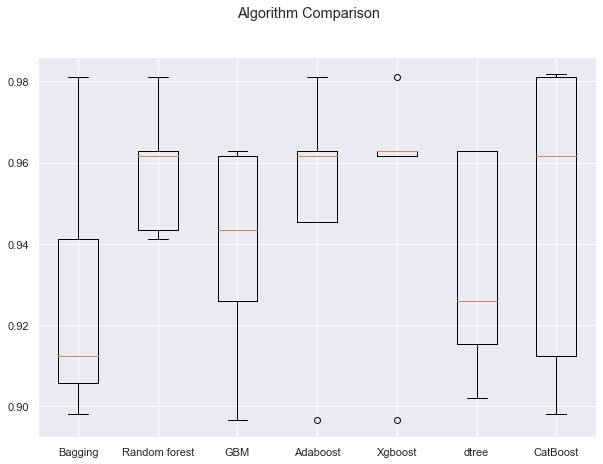

<IPython.core.display.Javascript object>

In [59]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

## task 12
- which model will you go with and why?

In [57]:
modelRF = RandomForestClassifier(random_state=1)

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

scoring = "f1"
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # Setting number of splits equal to 5
cv_result = cross_val_score(estimator=modelRF, X=X_train[selected_features], y=y_train, scoring=scoring, cv=kfold)

print("{}: {}".format("RF", cv_result.mean() * 100))


Cross-Validation Performance:



NameError: name 'X_train' is not defined

<IPython.core.display.Javascript object>

## Add features from highly_corr_features to see if we dropped any important feature

In [61]:

for f in highly_corr_features:
    selected_features_2 = selected_features.copy()
    selected_features_2.append(f)
    
    cv_result = cross_val_score(estimator=modelRF, X=X_train[selected_features_2], y=y_train, scoring=scoring, cv=kfold)

    print("Feature: {}: {}".format(f, cv_result.mean() * 100))

Feature: age: 98.89536878216123
Feature: loan_quarter: 96.60269848949093
Feature: loan_month: 95.91486780166025
Feature: cust_type_0 - Salaried: 96.21136375853358
Feature: cust_type_1 - Business: 96.21136375853358
Feature: location_Kisumu: 96.60269848949093
Feature: location_Mombasa: 96.60269848949093
Feature: location_Nairobi: 96.60269848949093
Feature: age_group_18-24: 96.21136375853358
Feature: age_group_25-34: 97.34343923023168
Feature: age_group_35-49: 96.21136375853358
Feature: age_group_50-64: 96.96608073966564
Feature: age_group_65-84: 96.25253013932259
Feature: age_group_85-150: 96.21136375853358
Feature: nature_of_city_city: 96.21136375853358
Feature: nature_of_city_town: 96.21136375853358


<IPython.core.display.Javascript object>

the following features improve performance
` age, loan_quarter, cust_type_0 - Salaried, location_Kisumu

# task 13
- which features will you from the list of highly correlated features and why?

In [62]:
# Add them to selected features
selected_features_new = selected_features.copy()
for i in ['age']:
    selected_features_new.append(i)

<IPython.core.display.Javascript object>

In [63]:
# Best model so far
cv_result = cross_val_score(estimator=modelRF, X=X_train[selected_features_new], y=y_train, scoring=scoring, cv=kfold)
print("Feature: {}: {}".format(f, cv_result.mean() * 100))

Feature: nature_of_city_town: 98.89536878216123


<IPython.core.display.Javascript object>

In [64]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#     return fi_df

<IPython.core.display.Javascript object>

In [65]:
 plot_feature_importance(modelRF.feature_importances_,X_train[selected_features_new].columns,'RANDOM FOREST')

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<IPython.core.display.Javascript object>